# Second class

## Table of Contents (times are approximated)

1. [Summary of the first class (0.5-1 h, depending on previous knowledge about OOP)](#summary)  
2. [Collaborative Filtering (~15 min)](#cf)  
   2.1 [Co-occurrence Matrix (1.5-2h)](#copurchase)
   <br></br>
   2.2 [Memory-based CF (1-1.5 h)](#memory-base)
   <br></br>
   2.3 [Model-based CF (2-2.5 h)](#model-base)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os

## Summary of the first class in code <a id='summary'></a>


### HOW TO CREATE A PYTHON LIBRARY

In [7]:
class movielens_100k(object):
    """
    This python class read the movielens-100k dataset and:
        . Preprocess train and test sets
        . Create a python dict that allows us to translate any item id to the corresponding movie title
    """
    
    def __init__(self, data_root, item_id_file='u.item', train_file='u2.base', test_file='u2.test', 
                 columns=['user_id', 'item_id', 'rating', 'timestamp']):
                
        self.data_root = data_root
        self.items_id_file = os.path.join(self.data_root, item_id_file)
        self.train_file = train_file
        self.test_file = test_file
        self.columns = columns
        self.__data = {}  # dictionary to store train and test data

### Para Poder tratarlo como diccionario        

    def __getitem__(self, dataset):
        """
        Get train and test data

        :param dataset: dataset name (String)
        :return: pandas dataframe
        """
        return self.__data[dataset]

    def __setitem__(self, key, value):
        """
        Store train and test data in the dictionary self.__data.

        :param key: name of the dataset (String)
        :param value: pandas dataframe
        """
        self.__data[key] = value
        
    def read_data(self, file, verbose=False):
        """
        Read file returning a pandas dataframe
        :param file: file path
        :param verbose: print the first rows of the data
        """
        datafile = os.path.join(self.data_root, file)
        data = pd.read_csv(datafile, sep='\t', names=self.columns)
        if verbose:
            print(data.head())
        return data
            
    def returnItemId(self, text, dict_ids):
        """
        Retrieves all the ids and titles for movies containing 'text' in its title
        :param text: string to be looked for in movies titles
        :param dict_ids: dicttionary of {id:title}

        :return: a list of (id,title) if text found in titles, and an empty list otherwise.
        """
        # convert input text to lowercase
        text_ = text.lower()
        # find occurances
        search = [(k, v.lower().find(text_)) 
                  for k,v in list(dict_ids.items())]

        # Get the IDs corresponding to the given text
        index = [k for k,v in search if v>-1]

        # Return a list with the id and the name
        out = []
        for i in index:
            out.append((i, dict_ids[i]))
        return out
    
    def check_data_consistency(self):
        """
        Check if one film has two or more ids
        """
        self.item_dict = {}
        with io.open(self.items_id_file, 'rb') as f:
            for line in f.readlines():
                record = line.split(b'|')
                self.item_dict[int(record[0])] = str(record[1])
                
        if len(set(self.item_dict.keys())) == len(set(self.item_dict.values())):
            self.unique_item_dict_ = self.item_dict
            return True
        else:
            self.duplicates_item_dict = {}
            for id_,name in list(self.item_dict.items()):
                if name not in self.duplicates_item_dict:
                    self.duplicates_item_dict[name] = [id_]
                else:
                    self.duplicates_item_dict[name] = self.duplicates_item_dict[name]+[id_]

            self.unique_id_item_dict ={}
            for i, lista_id in enumerate(self.duplicates_item_dict.values()) :
                for key in lista_id:
                    self.unique_id_item_dict[key] = i

            self.unique_item_dict_ = {self.unique_id_item_dict[k]:v 
                                for k,v in self.item_dict.items()}
            return False
    
    def correcting_non_unique_movies(self, data_df):
        """
        Preprocess data_df in case the check_data_consistency function fails
        """
        if not self.check_data_consistency():
            data_df['item_id'] = data_df['item_id'].apply(lambda x: self.unique_id_item_dict[x])
            
        return data_df
            
    def train(self, verbose=False):
        """
        Train data
        """
        self['train_set'] = self.read_data(self.train_file, verbose)
        self['train_set'] = self.correcting_non_unique_movies(self['train_set'])
        items = self['train_set'].item_id.unique()
        self.train_id_dict = {j:i for i,j in enumerate(items)}
        self['train_set']['item_id'] = self['train_set']['item_id'].apply(lambda x: self.train_id_dict[x])
        self.unique_item_dict = {self.train_id_dict[v]:self.unique_item_dict_[v] 
                                for v in items}
        self.n_users = self['train_set'].user_id.unique().shape[0]
        self.n_items = self['train_set'].item_id.unique().shape[0]
        self.n_pairs = self['train_set'].shape[0]
        if verbose:
            print('There are %s users, %s items and %s pairs in the test set' \
                  %(self.n_users, self.n_items, self.n_pairs))
    
    def test(self, verbose=False):
        """
        Test data
        """
        self['test_set'] = self.read_data(self.test_file, verbose)
        self['test_set']['item_id'] = self['test_set']['item_id'].apply(lambda x: self.unique_id_item_dict[x])
        self['test_set']['item_id'] = self['test_set']['item_id'].apply(lambda x: self.train_id_dict[x] if x in self.train_id_dict else -1)
        self['test_set'] = self['test_set'][self['test_set']['item_id']!=-1]
        if verbose:
            print('There are %s users, %s items and %s pairs in the test set' \
                  %(self['test_set'].user_id.unique().shape[0], self['test_set'].item_id.unique().shape[0], 
                    self['test_set'].shape[0]))
            
    def get_data(self, verbose=False):
        """
        A kind of main function to return train and test data together
        """
        self.train(verbose)
        self.test(verbose)

In [6]:
# Examples:
movielens = movielens_100k("../ml-100k/")
movielens.get_data() #Get train and test data

In [8]:
movielens['train_set'].head()

,user_id,item_id,rating,timestamp
0,1,0,4,878542960
1,1,1,3,876893119
2,1,2,3,889751712
3,1,3,5,887431973
4,1,4,4,875071561


In [9]:
movielens['test_set'].head()

,user_id,item_id,rating,timestamp
0,1,289,5,874965758
1,1,290,3,876893171
2,1,373,1,875072484
3,1,374,5,878543541
4,1,665,1,878542772


In [10]:
print(list(movielens.unique_item_dict[item_id] for item_id in [1,5,20]))

["b'Get Shorty (1995)'", "b'Richard III (1995)'", "b'Apollo 13 (1995)'"]


In [12]:
class popularity_models(object):
    """
    Implement the following popularity models:
        . Most rated movie (it is assumed that this is the most watched movie)
        . Most positively rated movie (rating > a given threshold)
        . Highest rated movie
    """
    def __init__(self, model, train_df):
        self.model_name = model
        self.train_df = train_df
    
    def mostRated(self):
        """
        Most rated movie model
        """
        return self.train_df.groupby('item_id')['user_id'].count().sort_values(ascending=False)

    def positiveRated(self, min_rating=4.0):
        """
        Most positively rated movie model (rating > min_rating)
        """
        return self.train_df[self.train_df.rating>=min_rating].groupby('item_id')['user_id'].count().sort_values(ascending=False) 
        
    def mean_rate_movies(self, min_ratings=50):
        """
        Highest rated movie model. Only items with more than min_ratings ratings are considered
        """
        listRatedMovies = self.train_df.groupby('item_id')['rating'].apply(list).reset_index()
        filteredListRatedMovies = listRatedMovies[listRatedMovies.rating.apply(lambda x: len(x)>min_ratings)]
        meanMovies = filteredListRatedMovies.rating.apply(lambda x: np.mean(np.array(x))).sort_values(ascending=False)
        return meanMovies
        
    def train(self, min_rating=4.0, min_ratings=50):
        """
        Train a popularity model (i.e., sort the item list according to a particular frequency metric)
        """
        if self.model_name == 'mostRated':
            self.model = self.mostRated()
        elif self.model_name == 'positiveRated':
            self.model = self.positiveRated(min_rating)
        elif self.model_name == 'mean_rate_movies':
            self.model = self.mean_rate_movies(min_ratings)
        else:
            raise ValueError('%s doesnot exist' % self.model_name)
        
    def predict(self, top_k, verbose=False):
        """
        Return the first top_k recommendation of the chosen popularity model
        """
        return self.model.index.values[:top_k]
    
    def get_titles(self, movies_ids, unique_item_dict):
        """
        Given a list of movies ids, this method return their titles
        """
        title = []
        for i, index in enumerate(movies_ids):
            id_ = index # id of the movie
            title.append(unique_item_dict[id_])

        print(title)
        

In [26]:
# Example: Most rated movie model
# mostRated
# positiveRated
# mean_rate_movies
p = popularity_models('mostRated', movielens['train_set'])
p.train()
p.model.head()

item_id
36     461
80     414
207    409
298    406
251    402
Name: user_id, dtype: int64

In [27]:
p.predict(3)

array([ 36,  80, 207])

In [28]:
p.get_titles(p.predict(3), movielens.unique_item_dict)

["b'Star Wars (1977)'", "b'Fargo (1996)'", "b'Contact (1997)'"]


In [33]:
# Example: Most rated movie model
# mostRated
# positiveRated
# mean_rate_movies
p2 = popularity_models('mean_rate_movies', movielens['train_set'])
p2.train()
p2.model.head()

93     4.538462
252    4.512821
816    4.511364
136    4.490196
410    4.470270
Name: rating, dtype: float64

In [34]:
p2_hat = p2.predict(5)

In [35]:
p2.get_titles(p2.predict(5), movielens.unique_item_dict)

["b'Wallace & Gromit: The Best of Aardman Animation (1996)'", 'b"Schindler\'s List (1993)"', "b'Close Shave, A (1995)'", "b'Wrong Trousers, The (1993)'", "b'Casablanca (1942)'"]


In [37]:
class Metrics():
    """
    Implement the two most important relevance's metric for RS:
        . Recall
        . MAP
    """
    def __init__(self, train_ids, test_ids, recommended_ids):
        
        self.zipped = list(zip(test_ids, train_ids, recommended_ids))
        
    def recall_per_user(self, N, test, recommended, train):
        """
        :param N: number of recommendations
        :param test: list of movies seen by user in test
        :param recommended: list of movies recommended

        :return the recall
        """   
        if train is not None: 
            rec_true = []
            for r in recommended:
                if r not in train:
                    rec_true.append(r)
            else:
                rec_true = recommended   
        intersection = len(set(test) & set(rec_true[:N]))
        return intersection / float(np.minimum(N, len(test)))
       
    def recall_at_n(self, topN):
        """
        Computes the mean recall@k, for k in topN
        :param topN: list of positions
        """
        out = []
        for k in topN:
            recall = np.mean([self.recall_per_user(k, test, recom, train)  for (test, train, recom) in self.zipped])
            out.append(recall)
            print("recall@%s=%.3f" %(k, recall))
        return out
                                       
    def apk(self, N, test, recommended, train):
        """
        Computes the average precision at N given recommendations.

        :param N: number of recommendations
        :param test: list of movies seen by user in test
        :param recommended: list of movies recommended

        :return The average precision at N over the test set
        """   
        if train is not None: 
            rec_true = []
            for r in recommended:
                if r not in train:
                    rec_true.append(r)
        else:
            rec_true = recommended    
        predicted = rec_true[:N] # top-k predictions

        score = 0.0 # This will store the numerator
        num_hits = 0.0 # This will store the sum of rel(i)

        for i,p in enumerate(predicted):
            if p in test and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits/(i+1.0)

        return score / min(len(test), N)

    def map_at_n(self, topN):
        """
        Computes the mean average precision at k, for k in topN
        :param topN: list of positions
        """
        out = []
        for k in topN:
            map_ = np.mean([self.apk(k, test, recom, train)  for (test, train, recom) in self.zipped])
            out.append(map_)
            print("map@%s=%.3f" %(k, map_))
        return out

In [40]:
# Example
topk = [5, 10, 20, 50]

trainUsersGrouped = movielens['train_set'].groupby('user_id')['item_id'].apply(list).reset_index().sort_index()
train_ids = trainUsersGrouped.item_id.values

In [42]:
trainUsersGrouped.head()

,user_id,item_id
0,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2,"[8, 14, 36, 80, 105, 218, 202, 206, 219, 220, ..."
2,3,"[199, 213, 250, 217, 251, 237, 238, 242, 252, ..."
3,4,"[6, 36, 209, 213, 230, 251, 239, 235, 255, 258..."
4,5,"[289, 290, 12, 17, 291, 28, 48, 292, 51, 53, 6..."


In [43]:
train_ids[0:3]

array([list([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217]),
     

In [56]:
testUsersGrouped = movielens['test_set'].groupby('user_id')['item_id'].apply(list).reset_index().sort_index()
test_ids = testUsersGrouped.item_id.values

predictions = trainUsersGrouped.item_id.apply(lambda x: p.predict(np.max(topk))).reset_index()
predictions_ids = predictions.item_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)

*****Recall*****
recall@5=0.156
recall@10=0.169
recall@20=0.183
recall@50=0.254
*****Map*****
map@5=0.195
map@10=0.153
map@20=0.122
map@50=0.090


In [57]:
predictions2 = trainUsersGrouped.item_id.apply(lambda x: p2.predict(movielens.n_items)).reset_index()
predictions2_ids = predictions2.item_id.values
m2 = Metrics(train_ids, test_ids, predictions2_ids)
print('*****Recall*****')
_ = m2.recall_at_n(topk)
print('*****Map*****')
_ = m2.map_at_n(topk)

*****Recall*****
recall@5=0.055
recall@10=0.077
recall@20=0.089
recall@50=0.123
*****Map*****
map@5=0.046
map@10=0.045
map@20=0.039
map@50=0.036


<img src="https://courses.edx.org/c4x/BerkeleyX/CS100.1x/asset/Collaborative_filtering.gif" alt="collaborative filtering" style="float: right; width: 300px"/>

## 4. Collaborative Filtering <a id='cf'></a>

Perhaps, one of the most succesful techniques for making personalized recommendations are the so called *collaborative filtering* (CF) algorithms. CF is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue X than to have the opinion on X of a person chosen randomly. 

The image at the right (from Wikipedia) shows an example of user's preference prediction using collaborative filtering. At first, people rate different items (like videos, images, games). After that, the system is making predictions about a user's rating for an item, which the user has not rated yet. These predictions are built upon the existing ratings of other users, who have similar ratings with the active user. For instance, in the image at the right the system has made a prediction, that the active user will not like the video.

In this part we will see three kinds of CF, of increasing complexity:

4.1 [CF with co-occurrence](#copurchase)

4.2 [Memory-based CF](#memory-base)

4.3 [Model-based CF](#model-base)

<a id='copurchase'></a>
## 4.1 Co-occurrence Matrix

The idea is to recommend movies similar to the movies already seen by a user. A measurement of similarity among items is obtained from the co-occurrence matrix. This is nothing else than the adjacency matrix of the graph of items created by users!!!

<table border="0" style="width:825px;border:0px;">
<tr>
    <td> 
        <img src="https://lucidworks.com/wp-content/uploads/2015/08/Les-Miserables-Co-Occurrence.png" style="width: 500px"/>
    </td>
    <td> 
        <img src="https://lucidworks.com/wp-content/uploads/2015/08/midnight-club-graph.png" style="width: 400px"/>
    </td>
</tr>
</table>


Define the co-ocurrance matrix, which have shape=[n_items,n_items]. Filter movies rated with rating >=4.0

Suggested steps:
* create a dictionary of movies per user: moviesPerUser ={user: array[movies]}
* co-ocurrance matrix: coMatrix

In [68]:
# create a dict of user_id: np.array(movie_id)
moviesPerUser = (movielens['train_set']
                 .query('rating >=4')
                 .groupby('user_id')['item_id'].apply(np.array)
                 .to_dict()
                )
moviesPerUser

{1: array([  0,   3,   4,   7,   8,   9,  10,  11,  13,  14,  15,  16,  18,
         20,  23,  26,  28,  29,  30,  31,  32,  33,  34,  36,  37,  38,
         41,  42,  43,  44,  45,  46,  47,  49,  50,  51,  56,  59,  60,
         62,  63,  64,  65,  67,  69,  70,  71,  72,  73,  76,  77,  79,
         80,  85,  86,  87,  88,  90,  92,  93,  94,  99, 101, 102, 105,
        106, 107, 109, 110, 111, 119, 120, 121, 123, 125, 126, 128, 129,
        130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145,
        146, 147, 148, 149, 152, 153, 154, 155, 156, 157, 158, 159, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 172, 174, 178, 179, 180,
        181, 184, 185, 186, 187, 191, 192, 193, 195, 196, 200, 201, 202,
        204, 207, 214, 216]),
 2: array([  8,  36,  80, 105, 218, 202, 206, 219, 220, 217, 222, 224, 227,
        228, 229, 233, 235, 237, 238, 239, 240, 235, 241, 244, 246, 249]),
 3: array([252, 258, 259, 261, 268, 271, 273, 274, 275]),
 4: array([  6,  36, 209, 23

In [74]:
moviesPerUserTest = {
    1: np.array([0,3]),
    2: np.array([0,2,3]),
    3: np.array([0,2,3]),
    4: np.array([1,2,3])
}

In [75]:
# build the co-occurrance matrix
coMatrix = np.zeros((4,4))
for movies in moviesPerUserTest.values():
    print(movies)
    for m in movies:
        print('bucle: ',m)
        coMatrix[m,movies] += 1

[0 3]
bucle:  0
bucle:  3
[0 2 3]
bucle:  0
bucle:  2
bucle:  3
[0 2 3]
bucle:  0
bucle:  2
bucle:  3
[1 2 3]
bucle:  1
bucle:  2
bucle:  3


In [76]:
# build the co-occurrance matrix
coMatrix = np.zeros((movielens.n_items, movielens.n_items))
for movies in moviesPerUser.values():
  
    for m in movies:
        
        coMatrix[m,movies] += 1

Visualize the matrix with the following piece of code:



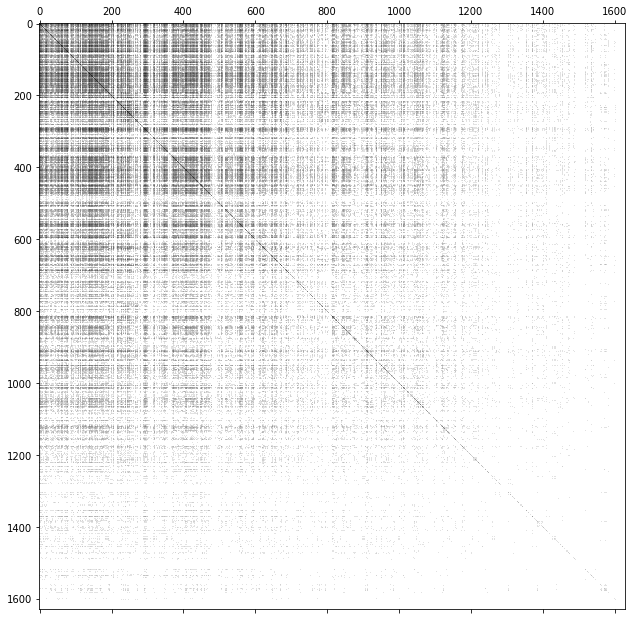

In [78]:
plt.matshow(np.log(coMatrix+1), fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [80]:
# Modelo de popularidad con index y veces vista esa película
p.model.head()

item_id
36     461
80     414
207    409
298    406
251    402
Name: user_id, dtype: int64

In [84]:
# Index del modelo de popularidad
p.model.index.tolist()[0:10]

[36, 80, 207, 298, 251, 229, 230, 289, 99, 238]

<div class="alert alert-success">
**QUESTION:** Can you think of a better way of visualizaing this matrix? Try to rescale it, or to rearrenge it follwoing some criteria (for instance, popularity!).
</div>

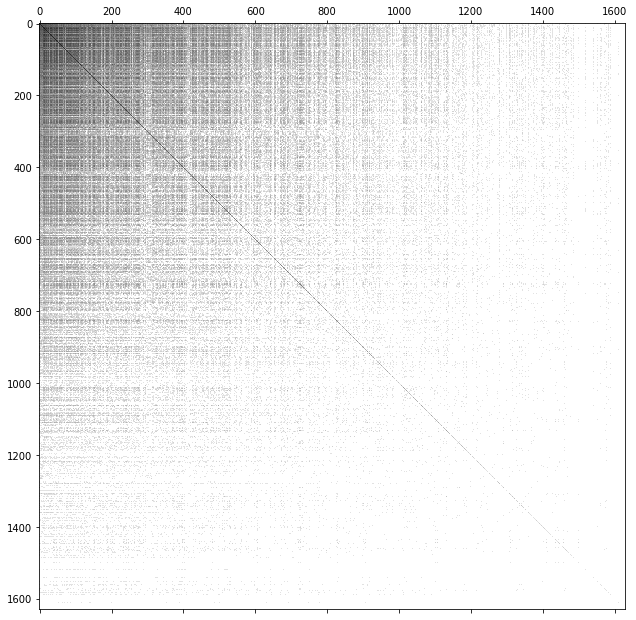

In [83]:

popular_indexing = p.model.index.tolist()
coMatrix_sorted = coMatrix[:,popular_indexing] # ordeno por columnas en todas las filas
coMatrix_sorted_total = coMatrix_sorted[popular_indexing,:] # ordeno por filas todas las columnas
log_scale = np.log(coMatrix_sorted_total+1.0)
plt.matshow(log_scale, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

#### 4.1.1 Making predictions using the co-occurrence matrix

This kind of recommendations, based on item similarity, provide a measure of the closeness of one item to another. In order to make a recommendation for a user, we have to proceed as follows:

* First, define a function that returns the top-N closest items to a given one.
* Then, for a list of items adopted by a specific user, select the top-N items from the lists of top-N closest items to each adopted item.

In [85]:
def co_occurrance_similarity(item_id, coocurrance, ntop=10):
    """
    Returns the top-N most similar items to a given one, based on the coocurrance matrix
    
    :param item_id: id of input item
    :param cooccurrance: 2-dim numpy array with the co-occurance matrix
    :param ntop: number of items to be retrieved
    
    :return top-N most similar items to the given item_id
    """
    similarItems = coocurrance[item_id,:]
    # return indeces of most similar items in descendign order: use numpy argsort
    mostSimilar = np.argsort(similarItems)[::-1]
    # remove the first element, as it is the item itslef
    mostSimilar = mostSimilar[1:ntop+1]
    
    # return a numpy array with the index (first column) and the value (second column) of the most similar items
    return np.stack((mostSimilar, similarItems[mostSimilar])).T

In [86]:
#TODO. Run the co_occurrance_similarity method
co_occurrance_similarity(49, coMatrix, 5)


array([[ 79., 124.],
       [140., 121.],
       [ 36., 118.],
       [139., 114.],
       [252., 111.]])

In [99]:
#TODO: Play with the movie ID, and print out its first Ntop recommendations!!
queryMovieId = 36
Ntop = 10
print('For item "%s" top-%s recommendations are:' % (movielens.unique_item_dict[queryMovieId], Ntop))

similarItems = co_occurrance_similarity(queryMovieId, coMatrix, Ntop)
# let's print out the first Ntop recommendations
for r in similarItems:
    print(int(r[0]), movielens.unique_item_dict[int(r[0])], r[1])

For item "b'Star Wars (1977)'" top-10 recommendations are:
298 b'Return of the Jedi (1983)' 217.0
140 b'Raiders of the Lost Ark (1981)' 193.0
139 b'Empire Strikes Back, The (1980)' 189.0
80 b'Fargo (1996)' 175.0
105 b'Godfather, The (1972)' 173.0
79 b'Silence of the Lambs, The (1991)' 169.0
289 b'Toy Story (1995)' 163.0
296 b'Princess Bride, The (1987)' 147.0
62 b'Fugitive, The (1993)' 145.0
77 b'Terminator 2: Judgment Day (1991)' 137.0


Now, let use this function to make recommendations:

In [94]:
#TODO
def co_occurrance_recommendation(items_id, cooccurrance, ntop=10):
    """
    Obtain the list of ntop recommendations based on a list of items (user history of views)
    
    :param items_id: list of items ids
    :param coocurrence: co-ocurrence matrix (numpy 2-dim array)
    :param ntop: top-K items to be retrieved
    
    :return list of ntop items recommended
    """
    # another (row wise)
    list_sim_items = np.vstack([co_occurrance_similarity(id_, cooccurrance, ntop) for id_ in items_id])
    # Group by id and take the maximum frquency to remove duplicates
    largest_freq = pd.DataFrame(list_sim_items, columns=['id', 'freq']).groupby('id').agg(max).reset_index()
    
    # sort by value in descending order
    sorted_list = largest_freq.sort_values(by='freq', ascending=False)
    
    # get the top N
    out = sorted_list.values[:ntop, 0]
    return out
    

Get the predictions (aka, recommendations)

Note that the predictions will be calculated for Ntop items. If you want the predictions for all the items, just set:

Ntop = movielens.n_items

Otherwise, choose your value. For instance:

Ntop = 200

The latter will be way faster.

In [95]:
# Ntop = movielens.n_items
Ntop = 200

In [97]:
trainUsersGrouped.head()

,user_id,item_id
0,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2,"[8, 14, 36, 80, 105, 218, 202, 206, 219, 220, ..."
2,3,"[199, 213, 250, 217, 251, 237, 238, 242, 252, ..."
3,4,"[6, 36, 209, 213, 230, 251, 239, 235, 255, 258..."
4,5,"[289, 290, 12, 17, 291, 28, 48, 292, 51, 53, 6..."


In [98]:
trainUsersGrouped.item_id.apply(lambda l: co_occurrance_recommendation(l, coMatrix, Ntop))

0      [298.0, 140.0, 36.0, 139.0, 80.0, 105.0, 79.0,...
1      [298.0, 140.0, 139.0, 80.0, 36.0, 105.0, 79.0,...
2      [36.0, 140.0, 79.0, 49.0, 139.0, 80.0, 447.0, ...
3      [298.0, 140.0, 139.0, 80.0, 105.0, 79.0, 289.0...
4      [36.0, 139.0, 140.0, 298.0, 79.0, 105.0, 62.0,...
5      [36.0, 140.0, 80.0, 105.0, 139.0, 79.0, 42.0, ...
6      [298.0, 36.0, 140.0, 139.0, 80.0, 105.0, 79.0,...
7      [36.0, 298.0, 140.0, 139.0, 80.0, 105.0, 79.0,...
8      [298.0, 140.0, 139.0, 80.0, 105.0, 79.0, 289.0...
9      [36.0, 140.0, 105.0, 80.0, 139.0, 42.0, 79.0, ...
10     [36.0, 105.0, 140.0, 79.0, 139.0, 4.0, 298.0, ...
11     [298.0, 36.0, 140.0, 139.0, 80.0, 105.0, 79.0,...
12     [36.0, 298.0, 140.0, 139.0, 80.0, 105.0, 79.0,...
13     [298.0, 36.0, 140.0, 139.0, 80.0, 105.0, 79.0,...
14     [36.0, 80.0, 298.0, 79.0, 140.0, 139.0, 42.0, ...
15     [36.0, 140.0, 139.0, 298.0, 79.0, 80.0, 105.0,...
16     [36.0, 105.0, 298.0, 79.0, 4.0, 80.0, 42.0, 28...
17     [298.0, 36.0, 140.0, 139

In [102]:
# use the dataframe trainUsersGrouped and the method co_occurrance_recommendation
predictions = trainUsersGrouped.item_id.apply(lambda l: co_occurrance_recommendation(l, coMatrix, Ntop)).reset_index()
predictions.head()

,index,item_id
0,0,"[298.0, 140.0, 36.0, 139.0, 80.0, 105.0, 79.0,..."
1,1,"[298.0, 140.0, 139.0, 36.0, 80.0, 105.0, 79.0,..."
2,2,"[36.0, 140.0, 79.0, 49.0, 139.0, 80.0, 447.0, ..."
3,3,"[298.0, 140.0, 139.0, 80.0, 105.0, 79.0, 289.0..."
4,4,"[36.0, 139.0, 298.0, 140.0, 79.0, 105.0, 62.0,..."


Note that, unlike previous popularity based models, the recommendation is now (slightly) different from one user to another

#### Evalute the recommendation

Get the `recall_at_n` for several n

In [104]:
topk = [5, 10, 20, 50]
predictions_ids = predictions.item_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
_ = m.recall_at_n(topk)

recall@5=0.163
recall@10=0.150
recall@20=0.094
recall@50=0.069


*Do the same analysis for the map metric*

In [105]:
_ = m.map_at_n(topk)

map@5=0.193
map@10=0.108
map@20=0.063
map@50=0.042


<div class = "alert alert-info">
Compare this results to those obtained with the popularity model. Was it so bad?
</div>

Some comments:
* The dataset we are using here is very simple. Indeed, you can see that the popularity baseline achieves quite decent metric values. This won't happen in a real world dataset! The reason it happens here is because the dataset is quite small, and quite biased towards popular items. 

* Recall does not account for the order of the recommendation, while map does. This explains why the co-occurrance model performs better after the first 10 recommendations in terms of map (ordering), while recall values are always better for the popularity based model.  


### 4.1.2 Oher distances

So far, we have defined the *closeness* of two items as the number of users shared. However, it would make make sense to define it relative the total number of users that have watch a movie. This can be done with the [Jaccard similarity index](https://en.wikipedia.org/wiki/Jaccard_index):

$$J(i,j)=\frac{|i\cap j|}{|i|+|j|-|i\cap j|}\in [0,1]$$


<div class = "alert alert-success">
Build the Jaccard similarity matrix from the co-occurrance matrix. Notice that $CoM(i,j) = |i\cap j|$ and $CoM(k,k) = |k|$. In addition, if both $|i|=0$ and $|j|=0$, the similarity is defined as 1 (this is a convention).
</div>

Define the Jaccard similarity matrix: jaccard

In [ ]:
jaccard = np.zeros((movielens.n_items, movielens.n_items)) # Jaccard similarity matrix
for i, row in enumerate(coMatrix):
    if row[i]!=0: # Case where the diagonal is not empty, i.e. coM(i,i)!=0
        jaccard[i,:] = ?
    else: # case where the diagonal is empty. We have to aasign a similarity of 1 to item pairs without ratings
        for j in np.arange(movielens.n_items):
            if coMatrix[j,j]==0:
                jaccard[i,j] = ?
            else: 
                jaccard[i,j] = ?

As before, let's visualize the matrix:

In [ ]:
plt.matshow(jaccard, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

Rearrange following popularity criteria (avoid ones!):


In [ ]:
popularity = popularity_models('mostRated', movielens['train_set'])
popularity.train()
popular_indexing = popularity.model.index.values.astype(np.int)
jaccard_sorted = jaccard[:,popular_indexing]
jaccard_sorted_total = jaccard_sorted[popular_indexing, :]

# Remove ones:
jaccard_sorted_total[jaccard_sorted_total == 1.0] = 0.0
cax = plt.matshow(jaccard_sorted_total, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.1, 0.2, 0.25])
plt.clim(0, 0.25)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

Recommend using Jaccard similarity:

In [ ]:
Ntop = 200
# Calculate the predictoins with Jaccard
predictions = ?
predictions.head()

#### Evaluate the recommendations

In [ ]:
topk = [5, 10, 20, 50, 100]
predictions_ids = predictions.item_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
_ = m.recall_at_n(topk)

In [ ]:
_ = m.map_at_n(topk)

<a id='memory-base'></a>
## 4.2. Memory-Based Collaborative Filtering (CF)

Although the methods developed so far return a list of recommended items, they cannot be used to make an actual prediction regarding the rating. A quite different approach would be to calculate the unknown rating, $r_{ui}$, as the averaged of some other ratings, thta are somehow close to either the user or the item in question. 

Thus, one approach is to take

### $$r_{u,i} = \frac{1}{K}\sum_{j\in\mathcal{I}'} \mathrm{sim}(i,j) r_{u,j},$$

where items $j\in\mathcal{I}'$ are taken from the set of $K$ closest items to $i$, or from the whole dataset. This is known as **item-item collaborative filtering**, and can be interpreted as *“users who liked this movie also liked …”*. See Amazon famous patent: https://www.google.com/patents/US7113917. Basically, this technique will take an item, find users who liked that item, and find other items that those users or similar users also liked. 

Similarly, one can define a **user-user filtering** where predictions are made as

### $$r_{u,i} = \frac{1}{K} \sum_{v\in\mathcal{U}'} \mathrm{sim}(u,v) r_{v,i}.$$

<img src="https://soundsuggest.files.wordpress.com/2013/06/utility_matrix.png" alt="utility matrix" style="float: right; width: 400px"/>

In this case, the recommendation would be more like *“users who are similar to you also liked …”*. Both techniques are part of the broad familiy of **Memory-Based Collaborative Filtering** approaches, or neighborhood-based algorithms.

The similarity among users or items can be calculated in a variety of forms: Pearson's correlation, cosine distance, etc. Here we will use the cosine distance. For this, we will first create the utility user-item matrix. 

The utility matrix is a dense representation of the user-item intearction. We have been using the *long* format, where missing entries are obviated; now, we will use the *wide* format, i.e. the matrix representation (see the figure on the right). 

<br></br>
<div class = "alert alert-info">
** NOTE **: Long and wide formats have its benefits and drawbacks. Can you think of some of them?
</div>

Put the train and test datasets in wide format (i.e., like a matrix). 

Name this variables uMatrixTraining and uMatrixTesting. 

Important!! Note user ids start at 1!

In [106]:
uMatrixTraining = np.zeros((movielens.n_users, movielens.n_items)) # utility matrix
for row in movielens['train_set'].values[:,0:3]:
    # Note user ids start at 1
    user_id = row[0] - 1
    item_id = row[1]
    rating = row[2]
    uMatrixTraining[user_id,item_id] = rating

In [107]:
uMatrixTesting = np.zeros((movielens.n_users, movielens.n_items)) # utility matrix
for row in movielens['test_set'].values[:,0:3]:
    # Note user ids start at 1
    user_id = row[0] - 1
    item_id = row[1]
    rating = row[2]
    uMatrixTraining[user_id,item_id] = rating

In [108]:
uMatrixTraining.nonzero()[0].size/uMatrixTraining.size

0.06483485026901482

In [ ]:
#TODO
def cosineSimilarity(ratings, kind='user', epsilon=1e-9):
    """
    Calculate the cosine distance along the row (columns) of a matrix for users (items)
    
    :param ratings: a n_user X n_items matrix
    :param kind: string indicating whether we are in mode 'user' or 'item'
    :param epsilon: a small value to avoid dividing by zero (optional, defaults to 1e-9)
    
    :return a square matrix with the similarities
    """
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ?
    elif kind == 'item':
        sim = ?
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T


### 4.2.1. User-user CF

*“Users who are similar to you also liked …”*

### $$r_{u,i} = \frac{1}{K} \sum_{v\in\mathcal{U}'} \mathrm{sim}(u,v) r_{v,i}.$$
Consider user $x$:

1. Find other users whose ratings are “similar” to $x$’s ratings, i.e. calculate the similarity among users with the help of the cosineSimilarity function.
2. Estimate missing ratings based on ratings of similar users

In [ ]:
userSimilarity = cosineSimilarity(uMatrixTraining, kind='user')

Have a look at the userSimilarity matrix:

In [ ]:
cax = plt.matshow(userSimilarity, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.25, 0.5])
plt.clim(0, 0.5)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

Now, get userItemCFpredictions

*Note that if we multiply `userSimilarity` by `uMatrixTraining` we get the ratings weigthed with user similar similarity. Then, we have to normalize by the average similarity for each user*

In [ ]:
norm = np.array([userSimilarity.sum(axis=1)]).T
userItemCFpredictions = userSimilarity.dot(uMatrixTraining) / norm

*Note that some users might give generally lower ratings than others, so that we could have also corrected for this effect as follows*

In [ ]:
sum_ = uMatrixTraining.sum(axis=1)
len_ =np.count_nonzero(uMatrixTraining, axis=1)
average_ratings = np.tile(sum_/ len_, movielens.n_items).reshape([movielens.n_items, movielens.n_users]).T
uMatrixTraining_shifted = uMatrixTraining - np.multiply(average_ratings, uMatrixTraining)
userItemCFpredictions_corrected = average_ratings + userSimilarity.dot(uMatrixTraining_shifted) / norm

### 4.2.2. Item-Item CF

*“Users who liked this movie also liked …”*

Consider item $i$, and following the previous section:

1. For item $i$, find other similar items, i.e. calculate the similarity itemSimilarity among items as before we did for users
2. Estimate rating for item $i$ based on ratings for similar items: itemItemCFpredictions



In [ ]:
itemSimilarity = cosineSimilarity(uMatrixTraining, kind='item')

In [ ]:
itemItemCFpredictions = uMatrixTraining.dot(itemSimilarity)/np.array([np.abs(itemSimilarity).sum(axis=1)])

### 4.2.3 Show some recommendations

In case of item-item CF, the recommendation is pretty much the same as with the co-occurence matrix. It's also quite simple to find similar items to a given one.

Find movies similar to a given one using the item-item similarity matrix.



In [ ]:
queryMovieId = 720
print("Selected item is '%s'" % movielens.unique_item_dict[queryMovieId])


queryAnswer = itemSimilarity[queryMovieId,:]
queryAnswer = np.argsort(queryAnswer)[::-1] #descending order
queryAnswer = queryAnswer[1:]  # remove first item (itself)

# let's print out the most similar items
Ntop = 10
print("Most %d similar movies are:" %Ntop)
printAnswer = queryAnswer[0:Ntop]
for answerId in printAnswer:
    print(movielens.unique_item_dict[answerId]+", with similarity %.2f" %itemSimilarity[queryMovieId, answerId])

Calculate the recommendations obtained with the item-item CF model.


In [ ]:
itemItemCFpredictions[uMatrixTraining>=4.0] = 0.0
for u in np.random.randint(0, movielens.n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Seen items: ")
    seen = uMatrixTesting[u,:]
    print([movielens.unique_item_dict[i] for i,r in enumerate(seen) if r>4.0])
    print("Recommended items: ")
    recom = itemItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([movielens.unique_item_dict[i] for i in recom])

<div class="alert alert-success">
Do the same with the user-user CF model.
</div>

In [ ]:
userItemCFpredictions[uMatrixTraining>=4.0] = 0.0
userItemCFpredictions_corrected[uMatrixTraining>=4.0] = 0.0
for u in np.random.randint(0, movielens.n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Seen items: ")
    seen = uMatrixTesting[u,:]
    print([movielens.unique_item_dict[i] for i,r in enumerate(seen) if r>4.0])
    print("Recommended items: ")
    recom = userItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([movielens.unique_item_dict[i] for i in recom])
    print("Recommended items (shifted version): ")
    recom = userItemCFpredictions_corrected[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([movielens.unique_item_dict[i] for i in recom])

**As you can see, the recommendations are pretty bad... Let's measure that**

### 4.2.4 Measure the recommendations

Since we are predicting ratings, it might make sense to introduce a metric that accounts for this. In particular, the **Root Mean Square Error (RMSE)** is typically used for this purpose. 

### $$\mathrm{RMSE}=\sqrt{\frac{1}{n_{\mathrm{users}}n_{\mathrm{items}}}\sum_{u,i}\left(r_{u,i}-\hat{r}_{u,i}\right)^2}$$

In [134]:
#TODO
from math import sqrt
def rmse(prediction, ground_truth):
    """
    Return the Root Mean Squared Error of the prediction
    
    :param prediction: a 2-dim numpy array with the predictions
    :param ground_truth: a 2-dim numpy array with the known ratings
    
    :return the RMSE
    """
    # get indices of non-zero elements at test
    r, c = ground_truth.nonzero()
    # get non-zero elements at prediction
    p = prediction[r,c]
    # get non-zero elements at test
    t = ground_truth[r,c]
    return sqrt(np.mean(np.power(p-t, 2.0)))

In [135]:
print('User-based CF RMSE=%.3f' %rmse(userItemCFpredictions, uMatrixTesting))

NameError: name 'userItemCFpredictions' is not defined

In [ ]:
print('Item-based CF RMSE=%.3f' %rmse(itemItemCFpredictions, uMatrixTesting))

### Calculate ranking metrics

In [136]:
# get all the recommendations
userItemCFpredictions_sorted = np.argsort(userItemCFpredictions)[::-1]
# get the first 200, to speed up things
userItemCFpredictions_sorted = userItemCFpredictions_sorted[:, :200]

test_ids = testUsersGrouped.item_id.values
train_ids = trainUsersGrouped.item_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: userItemCFpredictions_sorted[i-1]).values
topk = [5, 10, 20, 50, 100]
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)



NameError: name 'userItemCFpredictions' is not defined

<a id='model-base'></a>
## 4.3. Model-based CF or Latent factor models
There are several model-based CF: from matrix factorizations to bayesian models, neural netwroks, etc. In all of them, we try to extract latent factors (vectors) that model user and item interactions. In contrast to previous methods, our hypothesis here is that the dimension of the latent spaces is rather small (in the order of a hundred dimensions). Then, we use this latent features to make a prediction:

## $$r_{u,i} \approx {\bf f}_u^T\cdot{\bf f}_i$$

The underlying assumption is that both users and items *live* in the same latent space, and that we can unravel such space. 

<img src="https://www.researchgate.net/profile/Tunca_Dogan/publication/235913413/figure/fig3/AS:299678856957952@1448460415040/Figure-3-The-distribution-of-the-points-in-the-Swiss-roll-dataset-in-3-D-space.png
" alt="swiss roll" style="float: center; width: 300px"/>


Here we will use a couple of linear Matrix Factorization (MF) models:

* Singular Value decomposition (SVD)
* Alternating Least Squares (ALS)

### 4.3.1 Singular value decomposition

The main idea is to reduce the dimensionality of the input space. This is pretty much the same as Eigen-decomposition or Principal Component Analysis (PCA)-

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/220px-GaussianScatterPCA.svg.png
" alt="dimensionaly reducion" style="float: center; width: 500px"/>


In [137]:
from scipy.sparse.linalg import svds

Get SVD components from train matrix. Choose k=20.
# SVD es válido PARA MATRICES NO CUADRADAS PCA PARA CUADRADAS

In [138]:
k=20
u, s, vt = svds(uMatrixTraining, k)

Take a look at the different matrices
* check the shapes
* check if U and V are orthogonal matrices with the left singular vectors as columns

In [139]:
print(u.shape)
# Check U is orthogonal
print(rmse(np.dot(u.T,u), np.identity(k)))


(943, 20)
1.1699559521943108e-15


In [140]:
# Same with V
print(vt.shape)
print(rmse(np.dot(vt,vt.T), np.identity(k)))

(20, 1630)
8.036665142642832e-16


### Get the recommendations

We will reconstruct the utility matrix R (i.e., the recommendation matrix) as follows:

### $$M\approx U\mathrm{diag}(s)V^T$$

First, build a diagonal matrix s_diag_matrix with the eigenvalues




In [141]:
s_diag_matrix = np.diag(s)

Make the prediction: svdPredictions

In [142]:
svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)

Check if the dimensions of svdPredictions and uMatrixTesting are correct

In [143]:
print(svdPredictions.shape)
print(uMatrixTesting.shape)

(943, 1630)
(943, 1630)


### Evaluate the model

* Recall@{10,100}
* Play with more dimensions: svd_dim in {10, 50, 100}

In [152]:
print('SVD RMSE=%.3f' % rmse(svdPredictions, uMatrixTesting))

SVD RMSE=nan


/home/dsc/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dsc/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [145]:
# recall
svdPredictions_sorted = np.argsort(svdPredictions)[::-1]
svdPredictions_sorted = svdPredictions_sorted[:, :200]
test_ids = testUsersGrouped.item_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: svdPredictions_sorted[i-1]).values
topk = [10, 20, 50, 100]
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)

*****Recall*****
recall@10=0.055
recall@20=0.057
recall@50=0.071
recall@100=0.105
*****Map*****
map@10=0.037
map@20=0.027
map@50=0.021
map@100=0.020


In [146]:
for dim in [10, 50, 100]:
    print("*"*30)
    print("Using %s latent dimensions" %dim)
    # apply Singular Value Decomposition
    u, s, vt = svds(uMatrixTraining, dim)
    s_diag_matrix = np.diag(s)
    # make the prediction
    svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)
    print('SVD RMSE=%.3f' % rmse(svdPredictions, uMatrixTesting))
    # recall
    svdPredictions_sorted = np.argsort(svdPredictions)[::-1]
    svdPredictions_sorted = svdPredictions_sorted[:, :200]
    
    test_ids = testUsersGrouped.item_id.values
    predicted_ids = trainUsersGrouped.user_id.apply(lambda i: svdPredictions_sorted[i-1]).values
    topk = [5, 10, 20, 50, 100]
    m = Metrics(train_ids, test_ids, predicted_ids)
    print('*****Recall*****')
    _ = m.recall_at_n(topk)
    print('*****Map*****')
    _ = m.map_at_n(topk)

******************************
Using 10 latent dimensions


/home/dsc/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dsc/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


SVD RMSE=nan
*****Recall*****
recall@5=0.053
recall@10=0.048
recall@20=0.048
recall@50=0.060
recall@100=0.090
*****Map*****
map@5=0.047
map@10=0.033
map@20=0.024
map@50=0.019
map@100=0.019
******************************
Using 50 latent dimensions
SVD RMSE=nan
*****Recall*****
recall@5=0.055
recall@10=0.054
recall@20=0.057
recall@50=0.074
recall@100=0.109
*****Map*****
map@5=0.045
map@10=0.033
map@20=0.024
map@50=0.019
map@100=0.019
******************************
Using 100 latent dimensions
SVD RMSE=nan
*****Recall*****
recall@5=0.056
recall@10=0.052
recall@20=0.056
recall@50=0.081
recall@100=0.119
*****Map*****
map@5=0.041
map@10=0.029
map@20=0.022
map@50=0.018
map@100=0.018


### Implicit vs Explicit feedback

In the above SVD matrix factorization we have tried to reconstructt the matrix of ratings. However, it might be easier trying to model the matrix of preferences (i.e., wether the user likes or not a movie).

For this, we will define a “selector” matrix $I$ for the training utility matrix $R$, which will contain 0 if the rating matrix has no rating entry, and 1 if the rating matrix contains an entry. And the smae for testing data.


Convert uMatrixTraining and uMatrixTesting into implicit data (I and I2 respectively). For these new matrices, if r>3 then 1, else = 0

In [147]:
# Index matrix for training data
I = uMatrixTraining.copy()
I[I > 3] = 1
I[I == 0] = 0

In [148]:
# Index matrix for test data
I2 = uMatrixTesting.copy()
I2[I2 > 3] = 1
I2[I2 == 0] = 0

Evaluate SVD with RMSE, and recall@k and map@k, with k in [10, 30, 50, 100]

In [149]:
for dim in [50]:
    print("*"*30)
    print("Using %s latent dimensions" %dim)
    # apply Singular Value Decomposition
    u, s, vt = svds(I, dim)
    s_diag_matrix = np.diag(s)
    # make the prediction
    svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)
    print('SVD RMSE=%.3f' % rmse(svdPredictions, I2))
    # recall
    svdPredictions_sorted = np.argsort(svdPredictions)[::-1]
    svdPredictions_sorted = svdPredictions_sorted[:, :200]
    test_ids = testUsersGrouped.item_id.values
    predicted_ids = trainUsersGrouped.user_id.apply(lambda i: svdPredictions_sorted[i-1]).values
    topk = [10, 50, 100]
    m = Metrics(train_ids, test_ids, predicted_ids)
    print('*****Recall*****')
    _ = m.recall_at_n(topk)
    print('*****Map*****')
    _ = m.map_at_n(topk)

******************************
Using 50 latent dimensions


/home/dsc/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dsc/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


SVD RMSE=nan
*****Recall*****
recall@10=0.048
recall@50=0.066
recall@100=0.095
*****Map*****
map@10=0.028
map@50=0.016
map@100=0.016


### Overfitting

As we introduce more dimensions in the model, we make it more prone to overfit. This can be observed in the decrease of error (RMSE) in train, while it increases in test.

******************************
Using 2 latent dimensions


/home/dsc/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dsc/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


******************************
Using 5 latent dimensions
******************************
Using 10 latent dimensions
******************************
Using 20 latent dimensions
******************************
Using 40 latent dimensions
******************************
Using 80 latent dimensions
******************************
Using 200 latent dimensions


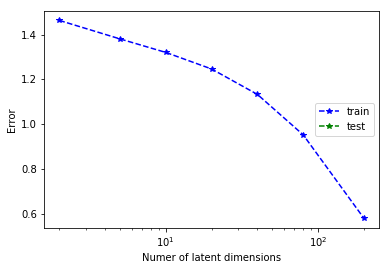

In [150]:
error_train = []
error_test = []
dims = [2, 5, 10, 20, 40, 80, 200]
for dim in dims:
    print("*"*30)
    print("Using %s latent dimensions" %dim)
    # apply Singular Value Decomposition
    u, s, vt = svds(I, dim)
    s_diag_matrix = np.diag(s)
    # make the prediction
    svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)
    error_train.append(rmse(svdPredictions, I))
    error_test.append(rmse(svdPredictions, I2)) 
plt.semilogx(dims, error_train, '--*b', label="train")
plt.semilogx(dims, error_test, '--*g', label="test")
plt.xlabel("Numer of latent dimensions")
plt.ylabel("Error")
plt.legend(loc=7)
plt.show()

**Note that after few dimensions (~10) the model starts to overfit (the error in test increases). Thus, we need to use other method to regularize the model (i.e., set restrictions/limitations to the model, so that it cannot overfit)**

### 3.2 Alternating Least Squares (ALS)

SVD can be very slow and computationally expensive. Besides, when addressing only the relatively few known entries we are highly prone to overfitting.

An scalable alternative to SVD is ALS, which can include regularization terms to prevent overfitting. We will rename our variable to make them more similar to the ALS notation

### ALS algorithm

The ALS algorithm aims to estimate two unknown matrices which, when multiplied together, yield the rating matrix. The loss function you will use is the well-known sum of squared errors. The second term is for regularisation to prevent overfitting

<img src="https://latex.codecogs.com/gif.latex?\underset{Q*&space;,&space;P*}{min}\sum_{(u,i)\epsilon&space;K&space;}(r_{ui}-P_u^TQ_i)^2&plus;\lambda(\left&space;\|&space;Q_i&space;\right&space;\|^2&space;&plus;&space;\left&space;\|&space;P_u&space;\right&space;\|^2)$&space;&space;$" title="\underset{q* , p*}{min}\sum_{(u,i)\epsilon K }(r_{ui}-q_i^Tp_u)^2+\lambda(\left \| q_i \right \|^2 + \left \| p_u \right \|^2)" />

The Alternating Least Squares algorithm does this by first randomly filling the users matrix with values and then optimizing the value of the movies such that the error is minimized.  Then, it holds the movies matrix constant and optimizes the value of the user's matrix.  This alternation between which matrix to optimize is the reason for the "alternating" in the name. 

<img alt="factorization" src="http://spark-mooc.github.io/web-assets/images/matrix_factorization.png" style="width: 885px"/>
<br clear="all"/>

This optimization is what's being shown on the right in the image above.  Given a fixed set of user factors (i.e., values in the users matrix), we use the known ratings to find the best values for the movie factors using the optimization written at the bottom of the figure.  Then we "alternate" and pick the best user factors given fixed movie factors.

It must be noticed that this is another way of reducing the dimensionality of the input matrix (like PCA, or more generally, SVD). This has important consequences:

* ### Our decomposition is linear. We won't be able to catch non-linear relationships among users and items.
* ### As in PCA or SVD, our features will correspond to directions of maximum variance in the data. Thus, the first feature will catch most of this variation, the second, a little bit more, and so on. It implies that the error in the reconstruction will not decrease dramatically when using more features!!! Keep this in mind.


In [ ]:
def alsRmse(I,R,P,Q):
    return np.sqrt(np.sum((I * (R - np.dot(P,Q.T)))**2)/len(R[R > 0]))

In [ ]:
import time
def iteration(user, fixed_vecs, counts, num_factors, reg_param, num_solve, verbose=False):
    num_fixed = fixed_vecs.shape[0]
    YTY = fixed_vecs.T.dot(fixed_vecs)
    eye = np.eye(num_fixed)
    lambda_eye = reg_param * np.eye(num_factors)
    solve_vecs = np.zeros((num_solve, num_factors))

    t = time.time()
    for i in range(num_solve):
        if user:
            counts_i = counts[i]
        else:
            counts_i = counts[:, i].T
        CuI = np.diag(counts_i)
        pu = counts_i.copy()
        pu[np.where(pu != 0)] = 1.0
        YTCuIY = fixed_vecs.T.dot(CuI).dot(fixed_vecs)
        YTCupu = fixed_vecs.T.dot(CuI + eye).dot(pu.T)
        xu = np.linalg.solve(YTY + YTCuIY + lambda_eye, YTCupu)
        solve_vecs[i] = xu
        if verbose and i % 300 == 0:
            print('Solved %i vecs in %d seconds' % (i, time.time() - t))
            t = time.time()

    return solve_vecs

In [ ]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

def check_als_performance(n_epochs, train_errors, test_errors):
    plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
    plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
    plt.title('ALS-WR Learning Curve')
    plt.xlabel('Number of Epochs');
    plt.ylabel('RMSE');
    plt.ylim(1, 5)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
num_iterations = 10
num_factors = 50
lmbda = 0.2  # this hyperparameter controlls the regularization. Play wiht it!
T = uMatrixTesting.copy()
ptest = uMatrixTesting.copy()
ptest[ptest > 0] = 1
ptest[ptest == 0] = 0
p = uMatrixTraining.copy()
p[p > 0] = 1
p[p == 0] = 0
R = uMatrixTraining.copy()
alpha = movielens.n_pairs / (movielens.n_users * movielens.n_items)
C = alpha * R
user_vectors = np.random.normal(size=(movielens.n_users, num_factors))
item_vectors = np.random.normal(size=(movielens.n_items, num_factors))
train_errors = []
test_errors = []
for i in range(num_iterations):
    print('Solving for user vectors...')
    user_vectors = iteration(True, item_vectors, C, num_factors, lmbda, movielens.n_users)
    print('Solving for item vectors...')
    item_vectors = iteration(False, user_vectors, C, num_factors, lmbda, movielens.n_items)
    print('iteration %i finished' % (i + 1))
    
    train_rmse = alsRmse(p,uMatrixTraining, user_vectors,item_vectors)
    test_rmse = alsRmse(ptest,uMatrixTesting, user_vectors,item_vectors)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    print("[Epoch %d/%d] train error: %f, test error: %f" 
        %(i+1, num_iterations, train_rmse, test_rmse))
    
print("Algorithm converged")



In [ ]:
check_als_performance(num_iterations, train_errors, test_errors)

### ALS evaluation
* RMSE
* recall@
* map@

In [ ]:
alsPredictions = np.dot(user_vectors, item_vectors.T)
svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)
print('ALS CF RMSE: ' + str(rmse(alsPredictions, uMatrixTesting)))
print('SVD CF RMSE: ' + str(rmse(svdPredictions, uMatrixTesting)))

In [ ]:
# evalutation
topk = [20, 50, 100]
alsPredictions_sorted = np.argsort(alsPredictions)[::-1]
alsPredictions_sorted = alsPredictions_sorted[:, :np.max(topk)]
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: alsPredictions_sorted[i-1]).values
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)